# Trabalho 5 - Mineração de Dados - DCC 127

## Professor: Heder Soares Bernardino

### Lucas Augusto Muller
### Pedro Henrique Muniz

In [ ]:
import numpy as np
import IPython
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import DBSCAN, MiniBatchKMeans, AgglomerativeClustering, OPTICS, MeanShift
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score, homogeneity_completeness_v_measure
from matplotlib.ticker import FixedLocator, FixedFormatter

from sklearn.tree import DecisionTreeClassifier
from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

In [ ]:
!git clone https://github.com/lucasmullers/mineracao-2020.3.git

fatal: destination path 'mineracao-2020.3' already exists and is not an empty directory.


# Importação dos dados

Inicialmente importamos o dataset, imprimimos as informações, checamos se existem dados faltantes e verificamos os tipos dos atributos no dataset.

In [ ]:
df = pd.read_csv( './mineracao-2020.3/trabalho5_dados_5.csv' )
display( df )

print( df.dtypes )
print( df.isnull().sum() )

,area,perimetro,maior-eixo,menor-eixo,arredondamento,area-convexa,extensao
0,11445,426.181000,172.977371,86.003540,0.867639,11734,0.611378
1,13607,461.050995,190.514343,91.712799,0.876503,13772,0.609141
2,14906,497.825012,211.341904,90.652954,0.903333,15150,0.597483
3,10249,404.088989,165.682449,80.384262,0.874419,10486,0.671449
4,13728,488.101990,208.974121,84.640854,0.914303,14052,0.557935
...,...,...,...,...,...,...,...
1138,8679,380.601013,158.235260,70.787994,0.894354,8889,0.718044
1139,12643,449.342010,184.778076,87.988708,0.879345,12903,0.772044
1140,12279,455.415009,191.653336,82.475700,0.902668,12549,0.592044
1141,9561,386.084991,159.970535,76.796448,0.877232,9708,0.700953


area                int64
perimetro         float64
maior-eixo        float64
menor-eixo        float64
arredondamento    float64
area-convexa        int64
extensao          float64
dtype: object
area              0
perimetro         0
maior-eixo        0
menor-eixo        0
arredondamento    0
area-convexa      0
extensao          0
dtype: int64


# Normalização dos dados

Após verificarmos que não existem dados faltantes e que os dados se tratam de valores numéricos, nós utilizamos a função MinMaxScaler para normalizar os dados no intervalo [0, 1].

In [ ]:
scaler = MinMaxScaler( )
df_scaled = pd.DataFrame( scaler.fit_transform(df), columns=df.columns )
display(df_scaled)

,area,perimetro,maior-eixo,menor-eixo,arredondamento,area-convexa,extensao
0,0.314845,0.316467,0.242621,0.523853,0.576666,0.327810,0.320462
1,0.545901,0.514462,0.443764,0.680560,0.633211,0.544296,0.313531
2,0.684728,0.723268,0.682650,0.651469,0.804348,0.690673,0.277406
3,0.187026,0.191027,0.158950,0.369616,0.619918,0.195241,0.506594
4,0.558833,0.668060,0.655492,0.486450,0.874322,0.574039,0.154867
...,...,...,...,...,...,...,...
1138,0.019237,0.057661,0.073533,0.106219,0.747076,0.025600,0.650970
1139,0.442877,0.447977,0.377971,0.578341,0.651334,0.451986,0.818292
1140,0.403976,0.482460,0.456828,0.427021,0.800105,0.414383,0.260555
1141,0.113498,0.088799,0.093436,0.271138,0.637860,0.112598,0.598012


# Checando correlação dos atributos

https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

Após a normalização dos dados nós checamos a correlação entre os atributos, e com isso percebemos que existem 6 pares de colunas com alta correlação, e 3 com correlação moderada.


In [ ]:
display( df_scaled.corr() )

,area,perimetro,maior-eixo,menor-eixo,arredondamento,area-convexa,extensao
area,1.000000,0.966354,0.902519,0.777601,0.361929,0.998979,-0.029295
perimetro,0.966354,1.000000,0.971405,0.617079,0.553036,0.969751,-0.103962
maior-eixo,0.902519,0.971405,1.000000,0.435978,0.719120,0.902577,-0.112167
menor-eixo,0.777601,0.617079,0.435978,1.000000,-0.297051,0.777555,0.090724
arredondamento,0.361929,0.553036,0.719120,-0.297051,1.000000,0.361900,-0.187832
area-convexa,0.998979,0.969751,0.902577,0.777555,0.361900,1.000000,-0.034846
extensao,-0.029295,-0.103962,-0.112167,0.090724,-0.187832,-0.034846,1.000000


In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_scaled, 10))

Top Absolute Correlations
area        area-convexa      0.998979
perimetro   maior-eixo        0.971405
            area-convexa      0.969751
area        perimetro         0.966354
maior-eixo  area-convexa      0.902577
area        maior-eixo        0.902519
            menor-eixo        0.777601
menor-eixo  area-convexa      0.777555
maior-eixo  arredondamento    0.719120
perimetro   menor-eixo        0.617079
dtype: float64


# Principal Component Analysis (PCA)

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

Para tratar os atributos com alta relação nós utilizamos o método do Principal Component Analysis (PCA), conforme explicado no capítulo 5 do livro "Python Data Science Handbook", para reduzir a quantidade de atributos e remover as alta correlações.

Inicialmente, nós plotamos a variância cumulativa explicada conforme demonstrado no livro, e através do gráfico percebemos que com 2 componentes conseguimos descrever quase 100% da variância dimensional. Portanto, nós aplicamos o PCA com n_components=2, e após a transformação nos checamos novamente a correlação entre os atributos para garantir que não houvesse grandes correlações.

[0.64366359 0.878444   0.99736938 0.99892531 0.99969119 0.99994526
 1.        ]


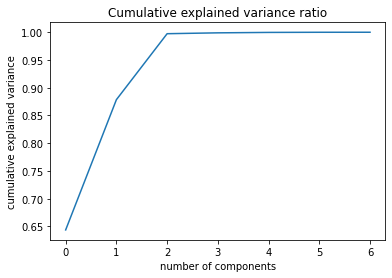

In [ ]:
pca = PCA().fit(df_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Cumulative explained variance ratio")
print(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
pca = PCA(n_components=2)
df_pca = pd.DataFrame( pca.fit_transform(df_scaled), columns=['Principal Component 1', 'Principal Component 2'])
display( df_pca )
print(df_pca.describe())

,Principal Component 1,Principal Component 2
0,-0.302839,-0.137139
1,0.148341,-0.101649
2,0.521609,-0.165624
3,-0.569511,-0.011033
4,0.346501,-0.344270
...,...,...
1138,-0.887890,0.033188
1139,-0.061068,0.347289
1140,-0.020306,-0.252903
1141,-0.751996,0.046648


       Principal Component 1  Principal Component 2
count           1.143000e+03           1.143000e+03
mean           -3.875582e-17          -1.614826e-17
std             4.016018e-01           2.425477e-01
min            -9.615998e-01          -5.886049e-01
25%            -3.184354e-01          -1.913355e-01
50%            -6.842621e-02          -3.263133e-02
75%             3.459189e-01           1.897451e-01
max             1.037996e+00           6.259571e-01


In [ ]:
display( df_pca.corr() )

,Principal Component 1,Principal Component 2
Principal Component 1,1.000000e+00,8.658065e-17
Principal Component 2,8.658065e-17,1.000000e+00


# Detecção e remoção de outliers (DBSCAN e Optics)

https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561

Em seguida, nós utilizamos os algoritmos de agrupamento DBSCAN e Optics para detectarmos outliers presentes nos dados. Primeiro utilizamos o Optics para auxiliar na definição dos parâmetros do DBSCAN, que foi o algoritmo responsável por detectar os outliers. Com os parâmetros utilizamos os algoritmos obtiveram 16 outliers, que foram removidos do dataset.

Optic Model
Number of clusters: {0, -1}


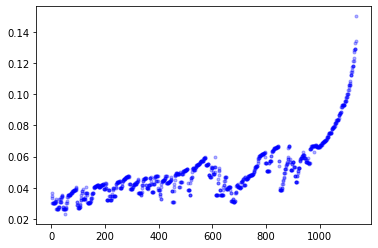

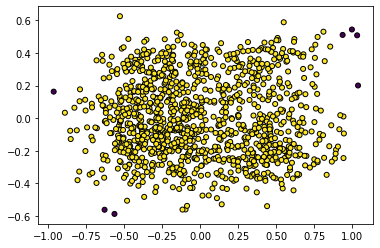

In [ ]:
opticModel = OPTICS(min_samples=10, max_eps=0.15, xi=0.15)
y_optic = opticModel.fit_predict(df_pca)

print('Optic Model')
print('Number of clusters: {}'.format(set(opticModel.labels_)))
space = np.arange(len(df_pca))
reachability = opticModel.reachability_[opticModel.ordering_]
labels = opticModel.labels_[opticModel.ordering_]
colors = [ "b.", "y.", "r.", "g.", "c." ]
for cclass, color in zip( range(0, 5), colors ):
  Xk = space[ labels==cclass ]
  Rk = reachability[ labels==cclass ]
  plt.plot(Xk, Rk, color, alpha=0.3)

plt.plot( space[ labels == -1 ], reachability[ labels==-1 ], "k.", alpha=0.3 )
plt.show()

plt.scatter( df_pca.iloc[:, 0], df_pca.iloc[:, 1], marker="o", c=y_optic, s=25, edgecolor="k" )
plt.show()

,Principal Component 1,Principal Component 2,outliers
0,-0.302839,-0.137139,0
1,0.148341,-0.101649,0
2,0.521609,-0.165624,0
3,-0.569511,-0.011033,0
4,0.346501,-0.344270,0
...,...,...,...
1138,-0.887890,0.033188,0
1139,-0.061068,0.347289,0
1140,-0.020306,-0.252903,0
1141,-0.751996,0.046648,0


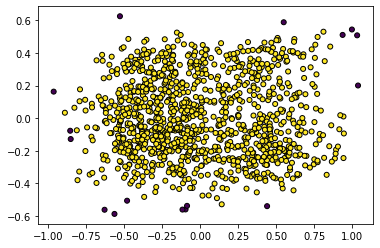

In [ ]:
dbscanModel = DBSCAN(eps=0.1, min_samples=5, metric='euclidean')
clustering = dbscanModel.fit(df_pca)
y_dbscan = dbscanModel.fit_predict(df_pca)

df_pca['outliers'] = clustering.labels_
display(df_pca)
plt.scatter( df_pca.iloc[:, 0], df_pca.iloc[:, 1], marker="o", c=y_dbscan, s=25, edgecolor="k" )
plt.show()

In [ ]:
df_cleaned = df_pca[df_pca['outliers'] != -1]
df_cleaned = df_cleaned.drop('outliers', axis=1).reset_index(drop=True)

df_scaled['outliers'] = clustering.labels_
df_scaled = df_scaled[df_scaled['outliers'] != -1]
df_scaled = df_scaled.drop('outliers', axis=1).reset_index(drop=True)

print( "Number of outliers: {}".format( np.count_nonzero(np.array(clustering.labels_), -1)) )
display( df_cleaned )

Number of outliers: 16


,Principal Component 1,Principal Component 2
0,-0.302839,-0.137139
1,0.148341,-0.101649
2,0.521609,-0.165624
3,-0.569511,-0.011033
4,0.346501,-0.344270
...,...,...
1122,-0.887890,0.033188
1123,-0.061068,0.347289
1124,-0.020306,-0.252903
1125,-0.751996,0.046648


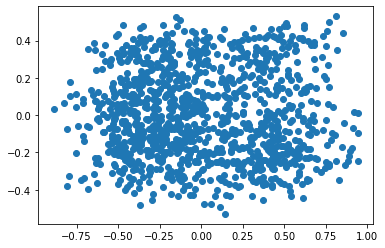

In [ ]:
plt.scatter( df_cleaned.iloc[:, 0], df_cleaned.iloc[:, 1], marker="o")
plt.show()

# MiniBatchKMeans

## Definição do número de clusters

Após realizarmos o pré-processamento dos dados, nós plotamos dois gráficos para tentar descobrir o número de clusters que gera os melhores resultados para os dados disponíveis.

O primeiro gráfico trata-se da "Silhuette Score" para valores de K = 2, 3, 4, 5, 6, 7, 8, 9, 10. Já o segundo gŕafico trata-se de um "Silhuette Diagram" para os valores de K = 2, 3, 4.

Analisando ambos os gráficos podemos concluir o melhor valor de n_clusters é 2.

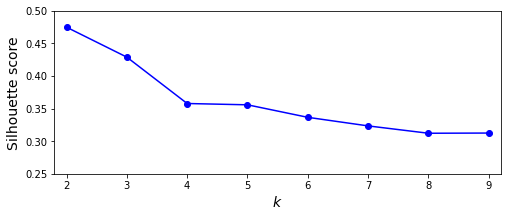

In [ ]:
minibatchkmeans_per_k = [MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=30).fit(df_cleaned.values) for k in range(1, 10)]
silhouette_scores = [silhouette_score(df_cleaned.values, model.labels_) for model in minibatchkmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 9.2, 0.25, 0.5])
plt.show()

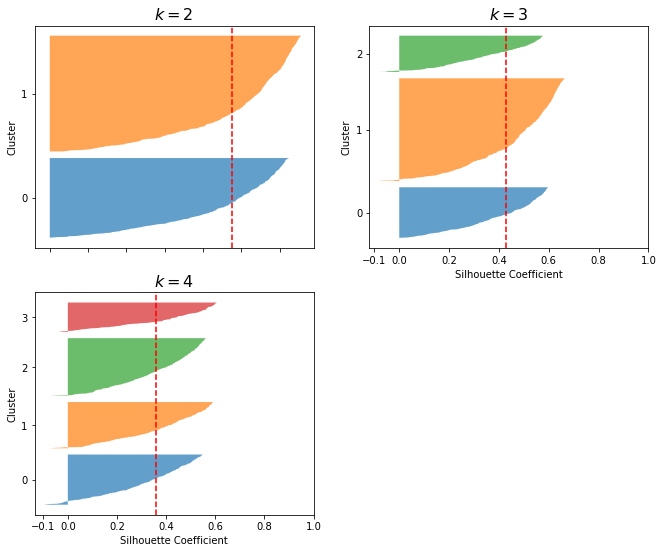

In [ ]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4):
    plt.subplot(2, 2, k - 1)
    
    y_pred = minibatchkmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(df_cleaned, y_pred)

    padding = len(df_cleaned) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.colors.ListedColormap(['royalblue', 'cyan', 'yellow', 'orange'])
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          cmap=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 3, 4):
        plt.ylabel("Cluster")
    
    if k in (3, 4):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
plt.show()

# Agrupamentos por MiniBatchKMeans, AgglomerativeClustering e MeanShift

Depois de tratarmos os dados de entrada e fazer um estudo inicial sobre o número de clusters, nós aplicamos os algoritmos de agrupamento: MiniBatchKMeans, AgglomerativeClustering e MeanShift. Para cada um desses algoritmos nós utilizamos o GridSearch (mecanismo para ajuste de parâmetros) com alguns valores pré-definidos, em busca do conjunto capaz de obter o melhor agrupamento segundo a métrica "Silhouette Score". O melhor resultado obtido por cada método é exibido em um gráfico de dispersão.

Analisando os gráficos é possível perceber que todos os métodos dividiram os dados em 2 grupos bastante parecidos, as principais diferenças aparecem em torno do valor 0.0 para o Principal Component 1.

{'bandwidth': 0.3}
{'affinity': 'euclidean', 'linkage': 'average', 'n_clusters': 2}
{'batch_size': 45, 'max_iter': 100, 'max_no_improvement': 15, 'n_clusters': 2, 'random_state': 42}

Agglomerative Model
Number of clusters: {0, 1}


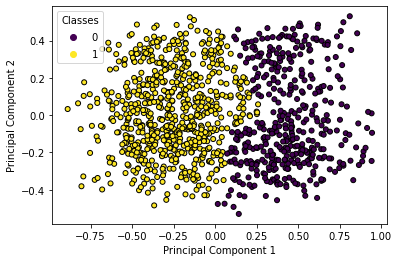


MeanShift
Number of clusters: {0, 1}


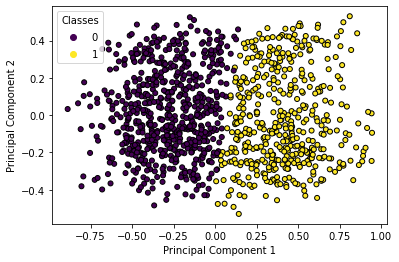


MiniBatchKMeans
Number of clusters: {0, 1}


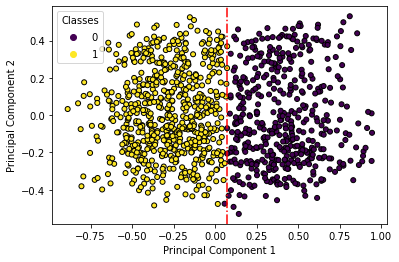

In [ ]:
def silhouette_scorer(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)

def grid_search(X, clusteringModel, param_dict):
    cv = [(slice(None), slice(None))]
    gs = GridSearchCV(estimator=clusteringModel, param_grid=param_dict, 
                    scoring=silhouette_scorer, cv=cv, n_jobs=-1)
    gs.fit(X)
    print(gs.best_params_)
    return gs.best_params_

best_params_ = grid_search(df_cleaned, MeanShift(), {'bandwidth': [0.25, 0.30, 0.35, 0.4, 0.45, 0.5]})
meanShiftModel = MeanShift(bandwidth=best_params_['bandwidth'])
y_mshift = meanShiftModel.fit_predict( df_cleaned )


best_params_ = grid_search(df_cleaned, AgglomerativeClustering(),
                           {'n_clusters': [2, 3, 4],  
                            'affinity': ['euclidean', 'manhattan'], 
                            'linkage': ['ward', 'complete', 'average', 'single']})
agModel = AgglomerativeClustering(n_clusters=best_params_['n_clusters'], 
                                  linkage=best_params_['linkage'], 
                                  affinity=best_params_['affinity'])
y_ag = agModel.fit_predict( df_cleaned )


best_params_ = grid_search(df_cleaned, MiniBatchKMeans(), {'n_clusters': [2, 3, 4, 5], 
                                                           'max_iter': [100, 125, 150], 
                                                           'batch_size': [15, 30, 45, 60], 
                                                           'random_state': [42], 
                                                           'max_no_improvement':[15, 25, 35, 45]})
miniKMeansModel = MiniBatchKMeans(n_clusters=best_params_['n_clusters'], 
                                 max_iter=best_params_['max_iter'], 
                                 batch_size=best_params_['batch_size'], 
                                 random_state=42, 
                                 max_no_improvement=best_params_['max_no_improvement'])
y_minikmeans = miniKMeansModel.fit_predict( df_cleaned )

# opticModel = OPTICS(min_samples=10, max_eps=0.15, xi=0.15)
# y_optic = opticModel.fit_predict(df_cleaned)

print('\nAgglomerative Model')
print('Number of clusters: {}'.format(set(agModel.labels_)))
scatter = plt.scatter( df_cleaned.iloc[:, 0], df_cleaned.iloc[:, 1], marker="o", c=y_ag, s=25, edgecolor="k" )
plt.legend(*scatter.legend_elements(), title="Classes")
plt.xlabel(df_cleaned.columns[0])
plt.ylabel(df_cleaned.columns[1])
plt.show()

print('\nMeanShift')
print('Number of clusters: {}'.format(set(meanShiftModel.labels_)))
scatter = plt.scatter( df_cleaned.iloc[:, 0], df_cleaned.iloc[:, 1], marker="o", c=y_mshift, s=25, edgecolor="k" )
plt.legend(*scatter.legend_elements(), title="Classes")
plt.xlabel(df_cleaned.columns[0])
plt.ylabel(df_cleaned.columns[1])
plt.show()

print('\nMiniBatchKMeans')
print('Number of clusters: {}'.format(set(miniKMeansModel.labels_)))
scatter = plt.scatter( df_cleaned.iloc[:, 0], df_cleaned.iloc[:, 1], marker="o", c=y_minikmeans, s=25, edgecolor="k" )
plt.legend(*scatter.legend_elements(), title="Classes")
plt.axvline(x=0.073, linestyle='-.', color='red')
plt.xlabel(df_cleaned.columns[0])
plt.ylabel(df_cleaned.columns[1])
plt.show()

# Avaliação dos Agrupamentos

## Silhueta

In [ ]:
metricsKmeans = silhouette_score(df_cleaned, y_minikmeans, metric='euclidean')
metricsAgg = silhouette_score(df_cleaned, y_ag, metric='euclidean')
metricsMS = silhouette_score(df_cleaned, y_mshift, metric='euclidean')

print("Silhouette Score Kmeans: {}".format(metricsKmeans))
print("Silhouette Score Agg: {}".format(metricsAgg))
print("Silhouette Score MeanShift: {}".format(metricsMS))

Silhouette Score Kmeans: 0.47494958619053296
Silhouette Score Agg: 0.4620541884919098
Silhouette Score MeanShift: 0.4730820614029748


# Decision Tree

https://towardsdatascience.com/interpretable-clustering-39b120f95a45

Como forma de interpretarmos as principais características que culminaram na formação dos grupos, nós utilizamos Árvores de Decisão, já que se trata de um algoritmo conhecido por ser intuitivo e de fácil interpretação. A utilização de Árvores de Decisão no entendimento das características dos grupos é mostrado no link acima.



## MiniBatchKMeans

Como podemos ver na árvore de decisão criada com uma profundida máxima = 2, os dados com o atributo "Principal Component" <= 0.073 são agrupados no cluster 0 e os demais no cluster 1. Utilizando esta regra apenas 2 pontos são classificados de forma incorreta.

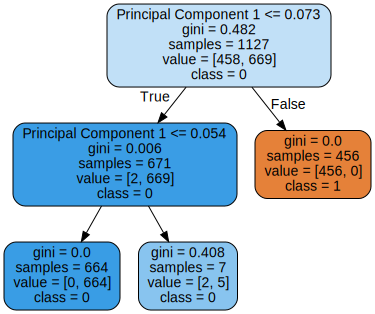

In [ ]:
X = df_cleaned
y = y_minikmeans

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

export_graphviz(
        tree_clf,
        out_file=os.path.join("./minibatchkmeans.dot"),
        feature_names=X.columns,
        class_names= ['1', '0'],
        rounded=True,
        filled=True
    )
Source.from_file(os.path.join("./minibatchkmeans.dot"))

## Agglomerative

No caso do AgglomerativeClustering, os dados agrupados na classe 0 possuem uma das seguintes características:

*  "Principal Component 1" <= 0.073 e -0.48 < "Principal Component 2" <= -0.464;
*  0.073 < "Principal Component 1" <= 0.212 e "Principal Component 2" <= -0.06;
*  "Principal Component 1" > 0.212;

Já os dados agrupados na classe 1 possuem uma das seguintes características:
*   "Principal Component 1" <= 0.073 e "Principal Component 2" > -0.464;
*  "Principal Component 1" <= 0.073 e "Principal Component 2" <= -0.480;
*  0.073 < "Principal Component 1" <= 0.212 e "Principal Component 2" > -0.06.

Seguindo essas características apenas 13 pontos foram designados para o agrupamento errado.

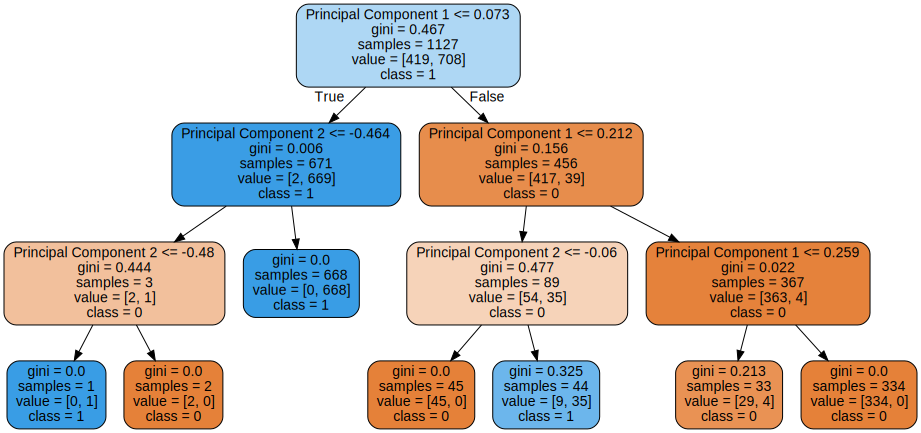

In [ ]:
X = df_cleaned
y = y_ag

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X, y)

export_graphviz(
        tree_clf,
        out_file=os.path.join("./agg.dot"),
        feature_names=X.columns,
        class_names= ['0', '1'],
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join("./agg.dot"))

## Mean Shift

No caso do Mean Shift, os dados agrupados na classe 0 possuem uma das seguintes características:
*   "Principal Component 1" <= 0.006; 
*   0.006 < "Principal Component 1" <= 0.045 e "Principal Component 2" >  -0.215;
*    0.045 < "Principal Component 1" <= 0.116 e "Principal Component 2" > 0.098;

Já os dados agrupados na classe 1 possuem uma das seguintes características:
*   0.006 < "Principal Component 1" <= 0.045 e "Principal Component 2" <=  -0.215;
*   0.045 < "Principal Component 1" <= 0.116 e "Principal Component 2" <= 0.098;
*   "Principal Component 1" > 0.116

Seguindo essas características apenas 5 pontos foram designados para o agrupamento errado.




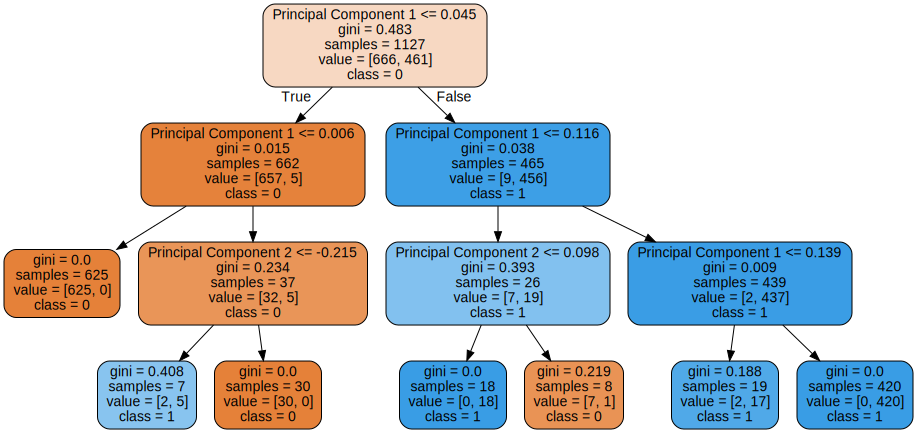

In [ ]:
X = df_cleaned
y = y_mshift

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X, y)

export_graphviz(
        tree_clf,
        out_file=os.path.join("./meanshift.dot"),
        feature_names=X.columns,
        class_names= ['0', '1'],
        rounded=True,
        filled=True
    )
Source.from_file(os.path.join("./meanshift.dot"))